# FishML

### Main Authors: 
- Fearghal O'Donncha, Ph.D and Paulito Palmes, Ph.D (IBM Research Europe - Dublin) <br>
### Collaborators
- Caitlin L. Stockwell (Dalhousie University, Canada), <br>
- Sonia Rey Planellas (University of Stirling, Scotland), <br>
- Giulia Micallef (Gildeskål Research Station, Norway), <br>
- Chris Webb (Cooke Aquaculture, Scotland), <br>
- Ramon Filgueira (Dalhousie University, Canada) and <br>
- Jon Grant (Dalhousie University, Canada),

### Overview
We present an analysis of environmental and hydroacoustic data salmon farm in Norway. We use statistical and machine learning approaches to interrogate the primary environmental drivers of changes in fish dynamics within a net pen.  Information on fish behaviour were collected using hydroacoustic sensors that sampled the vertical distribution of fish in a cage at high spatial and temporal resolution, while a network of environmental sensors characterised local site conditions.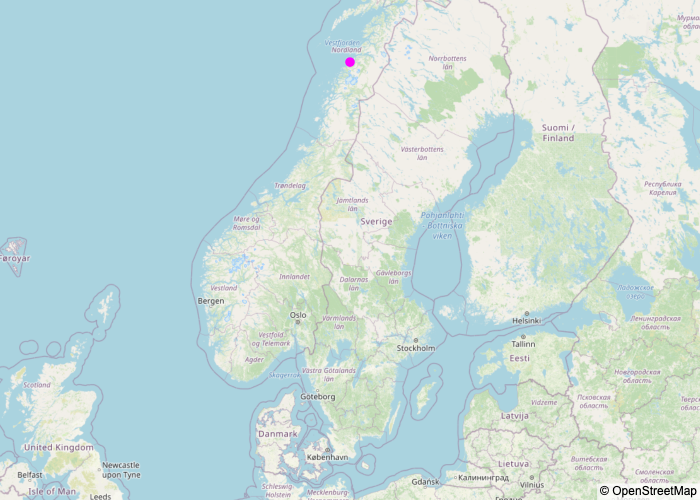


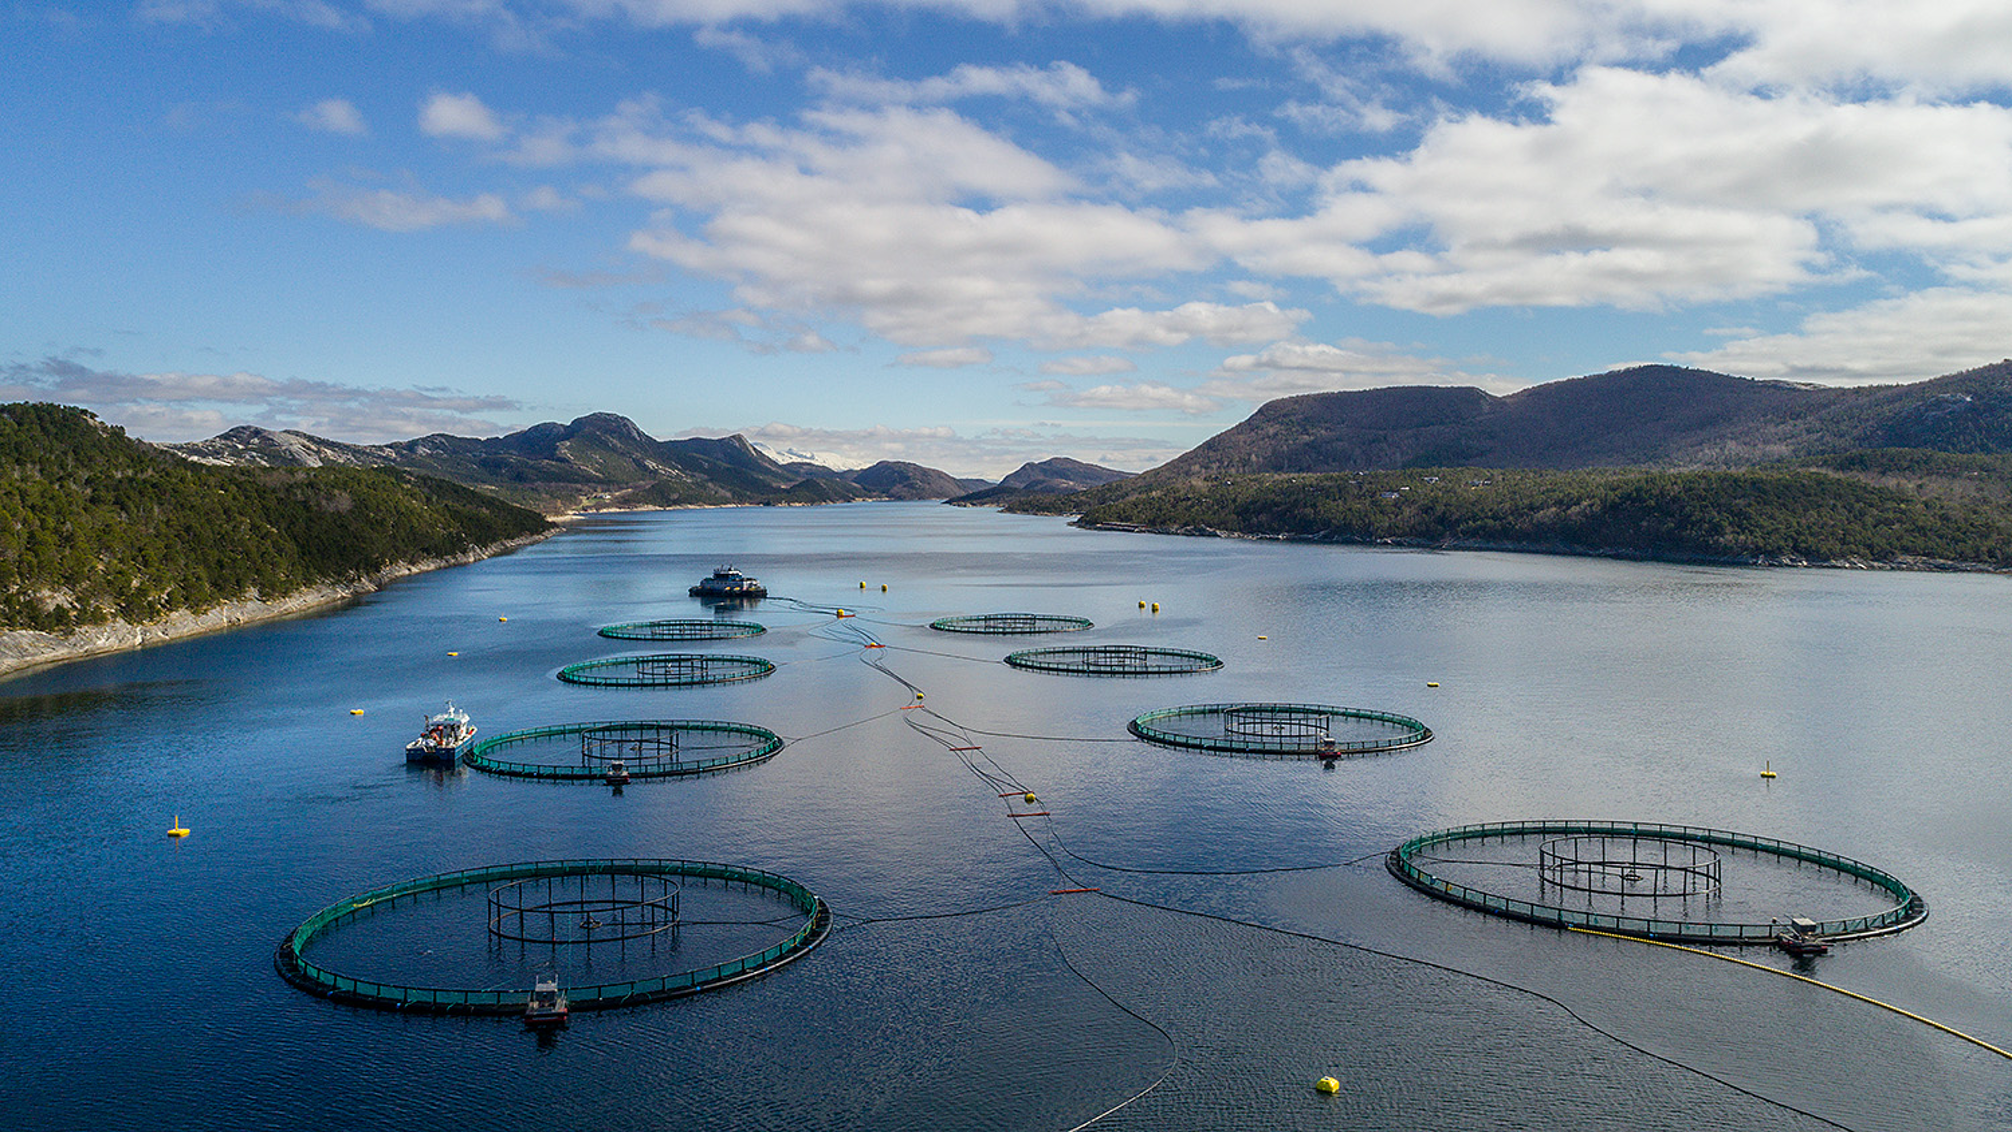

### Activate FishML package

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.update()


### Load packages

In [2]:
using PrecisionAquaculture
using TSML
using RCall
using DataFrames
using DataFramesMeta
using CSV
#using Impute
ENV["COLUMNS"]=1000 # for dataframe column size
sy=Symbol;

### Visualization of data
Hydroacoustic methods provide a proxy measure for density and distribution of marine animals in form of acoustic backscattering. The fundamental principle is based on emitting a signal of known type and power level from a transducer. As it encounters regions of the medium with differing properties, also called heterogeneities, the sound is generally redistributed, or scattered, in all directions. This makes possible detection of the scattered sound with transducer and suitable receiver electronics. Advantages linked to hydroacoustic sampling techniques include, high spatial and temporal resolution, autonomous long-term sampling duration, range (especially during poor visibility when visual-based methods tend to fail), and a non-invasive surveying approach. Given these advantages, hydroacoustics are increasingly used to characterise animal behaviour in the marine environment, and considered a promising system to improve management of aquaculture farms
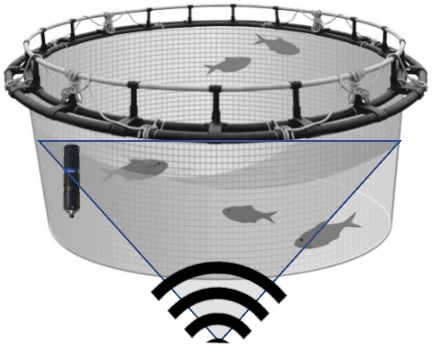

### Load data and visualize

In [3]:
fname="cage_sensors/all-abmdata.csv"
mdata=readdata(fname,"y-m-d H:M:S",:Timestamp) # field with date format
mdata[!, :Timestamp] = mdata[!, :Timestamp] - Dates.Hour(2)  # Since all our other data are in UTC format, let's combine on that and then readjust
head(x)=first(x,5);
tail(x)=last(x,5);
head(mdata)

5×23 DataFrame
 Row │ Timestamp            01      02      03      04      05      06      07      08      09      10      11      12      13      14      15      16      17      18      19      20      AverageDepth  StandarDeviation 
     │ DateTime             Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Int64?  Float64?      Float64?         
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 2019-02-20T18:00:00      44     922    1301    1278    1376    1285    1163    1094    1002     881     846     802     724     708     706     711     723     599     286     133       8.64161           4.94345
   2 │ 2019-02-20T19:00:00     226    6120    8687    8416    8227    7739    7380    7058    6452    5810    5268    5040    4697    4460    4515    4491    4825    4068    2468    1525       8.78975           5.07718
   3 │ 2019-02-20T20:00:00     256    6607    9827    9512    8789    7943    7438    6700    6226    5842    5401    5233    4756    4407    4455    4212    4395    3755    2205    1451       8.51274           5.0421
   4 │ 2019-02-20T21:00:00     259    7817   11746   11118   10195    9120    8289    7734    7040    6117    5076    4509    3716    3740    2931    2317    2077    1641    1097     795       7.31787           4.46607
   5 │ 2019-02-20T22:00:00     181    3485    4793    4726    4398    3935    3171    2006    1422    1016     652     503     391     407     162     133      89      31      32      29       5.17575           3.05146

┌ Warning: RCall.jl: Loading required package: reshape2
│ Loading required package: ggplot2
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160


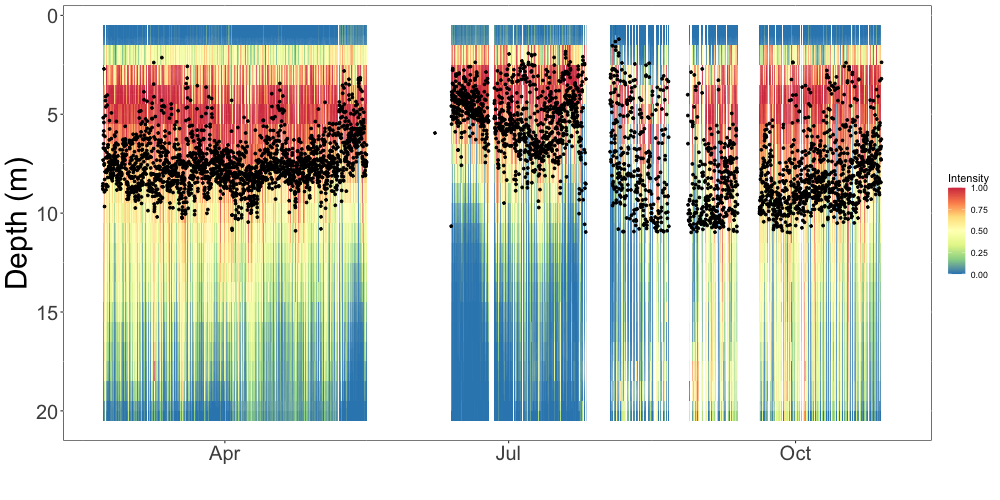

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 29260 rows containing non-finite values (stat_contour).
│ Warning: Removed 113988 rows containing missing values (geom_point).
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160


In [4]:
@rput mdata
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500));
R"""
source("./UtilityFunctions_ABM.R")  # Misc utility functions
ec_r <- matrix(unlist(mdata[,2:21]),ncol=length(mdata)-3,
               dimnames = list( c(mdata$Timestamp), c(sprintf(seq(1,20), fmt = "%02d"))))
# normalize to between 0 and 1
norm_0_2_1 = t(apply(ec_r, 1, function(x)(x-min(x))/(max(x)-min(x))))  # normalised for visualisation
## More sophisticated contour plot with ggplot
df <- melt(norm_0_2_1)
colnames(df) <- c("Timestamp", "depth", "Intensity")
df$Timestamp <-as.POSIXct(as.numeric(df$Timestamp), origin = "1970-01-01", tz = "Europe/Oslo")
df$ave_depth <- NA
df$std_dev <- NA
df$ave_depth[df$depth==1] <- mdata[,22]  # \  
df$std_dev[df$depth==1] <- mdata[,22]    # /
p2 <- plot_vert_distr(df)
p2 <- p2  +  scale_y_continuous(trans = "reverse");
"""


### Extract hourly mean height of fish locations

In [5]:
rowmean = extractgrmean(FVal(:abm),mdata)
hourlyheight=hourly(rowmean) .|> identity  # remove union types
# Linear interpolate to eliminate any Nans
#hourlyheight = Impute.interp(hourlyheight.Height)
rename!(hourlyheight,Dict(:Value => :Height));


### Extract hourly readings of environmental measurements
Conceptually, the cultivation of fish in the ocean has parallels with terrestrial livestock farming. In practice however, aquaculture is even more dependent on ambient environmental conditions than its land-based counterpart where animals can be housed. <br>
Multiple environmental variable impact on aquaculture growth conditions and need to be highly monitored to allow informed and effective decision making. Common variables collected sampled include temperature, current velocity, dissolved oxygen (DO), chlorophyll, and salinity. 

In [6]:
# temp
temp3m = "cage_sensors/Temperature_3m.csv"
temperature_sens=extractsensor(temp3m,:temperature_sens)
# oxygen
oxyfname = "cage_sensors/Oxygen_12m.csv"
hoxy12m_sens = extractsensor(oxyfname,:oxygen_sens)
# salinity
salinityfname = "cage_sensors/Salinity_6m.csv"
salinity_sens = extractsensor(salinityfname,:salinity_sens)
# speed
speedfname = "cage_sensors/Speed_5m.csv"
speed_sens = extractsensor(speedfname,:current_speed_sens)
# speed direction
spdirfname = "cage_sensors/SpeedDirection_5m.csv"
direction  = extractsensor(spdirfname,:current_direction);

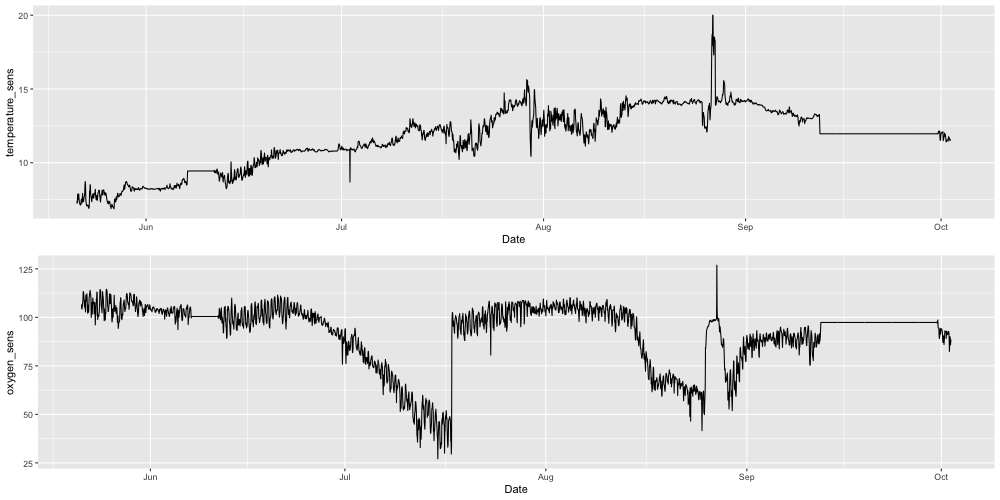

RObject{VecSxp}
TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]


In [7]:
@rput  temperature_sens hoxy12m_sens
R"""
library(ggplot2);library(gridExtra)

p1 = ggplot(data=temperature_sens,aes(Date, temperature_sens))+geom_line(color = 'black');
p2 = ggplot(data=hoxy12m_sens,aes(Date, oxygen_sens))+geom_line( color = 'black') ;
g = grid.arrange(p1,p2, nrow=2);
"""

## Numerically generated datasets
Collecting data in the ocean is not easy! Often times it is problematic to get complete data coverage over a period and various data imputation or data cleansing is necessary. Obviously there are textbooks that consider the topic of data imputation. However, it is problematic in environmental systems (and all systems) as there is strong potential to corrupt the signal with statistical imputation methods. <br>

Alternatively, one can rely on data from numerical models such as weather forecast products or ocean simulations. 

### Ocean model datasets
We extracted environmental model data from the _NorKyst-800 ocean model_ (Albretsen et. al. 2011). 
The NorKyst-800 is a numerical ocean modeling system deployed to simulate physical oceanography variables such as sea level, temperature, salinity and, currents for all coastal areas in Norway and adjacent seas. The model has a horizontal resolution of 800m, 35 layers in the vertical, and can be downloaded from the OPeNDAP server provisioned by the Norwegian Meteorological Institute. The model provides a satisfactory representation of Norwegian off- and onshore dynamics but requires higher resolution to resolve the dynamics of most Norwegian fjords properly (Albretsen et. al. 2011). <br>
Hence, it can be considered an imperfect but pragmatic approach to augment data coverage. We extract salinity, temperature, current speed, and sea surface height from the _Norkysyt_ ocean model

__References__
Albretsen, J., Sandvik, A. D., and Asplin, L. (2011). NorKyst-800: A high-resolution coastal ocean circulation model for Norway. Tech. rep., Institute of Marine Research

In [8]:
# When we use sensor data we are constrained to the period data is available
# How about instead we use the norksy model data
spsalfname = "norkyst_model/norkyst_salinity.csv"
salinity = extractsensor(spsalfname,:salinity);
sptempfname = "norkyst_model/norkyst_temperature.csv"
temperature = extractsensor(sptempfname,:temperature);
spspeed = "norkyst_model/norkyst_oceanspeed.csv"
speed = extractsensor(spspeed,:current_speed);
spdirection = "norkyst_model/norkyst_oceandirection.csv"
direction = extractsensor(spdirection,:current_direction);
elevationf = "norkyst_model/norkyst_waterlevel.csv"
elevation = extractsensor(elevationf,:SSH);

### Weather data
We extracted atmospheric data from IBM's _Environmental Intelligance Suite_ historical data product. Variables extracted were 2m temperature, downward and diffuse solar radiation, wind data, cloud cover, and precipitation. All data were at hourly intervals and from a 4km gridded dataset (note that the use of weather product instead of sensor also served to circumvent potential issues of incomplete coverage). 

In [9]:
# get weather info
weatherfname = "weather_data/WeatherData.csv"
weather = readdata(weatherfname,"y-m-d H:M:S+S:S",:timestamp);
head(weather)
colnames = ["timestamp","surface_temperature","downward_solar_radiation", 
    "diffuseHorizontalRadiationWsqm", "wind_speed", "wind_direction", "cloud_cover", "precipitation"]
rename!(weather, Symbol.(colnames));


### Handling cyclical features
Directional data (wind and ocean speed) is a rotational data, which can be troublesome. proper handling of such features involves representing the cyclical features as (x,y) coordinates on a circle. <br> 
We map each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sin and cos trigonometric functions. <br>
We apply same transformation for wind and ocean direction data

In [10]:
# windBearing is a rotational data, which can be troublesome, so it's converted to sine and cosine components 
weather[!,:wind_sindir]= sin.(weather[!, :wind_direction]*pi/180.);
weather[!,:wind_cosdir] = cos.(weather[!, :wind_direction]*pi/180.);
# drop the winddirection column and use instead the cyclical features
#weather = select!(weather, Not(:wind_direction))
# Similar for ocean direction
direction[!,:sindir]= sin.(direction[!, :current_direction]*pi/180.);
direction[!,:cosdir] = cos.(direction[!, :current_direction]*pi/180.);
#direction = select!(direction, Not(:current_direction))


### Create dataframe consisting of environmental and hydroacoustic datasets

In [11]:
# merge date,height,temp,oxygen
df = innerjoin(innerjoin(hourlyheight,temperature,on=:Date),salinity,on=:Date)
df = innerjoin(innerjoin(innerjoin(innerjoin(df,weather,on=:Date=>:timestamp),speed,on=:Date),direction,on=:Date), elevation, on=:Date)
df_sens = innerjoin(innerjoin(temperature,temperature_sens,on=:Date), salinity_sens, on=:Date)
df_sens_corr = innerjoin(innerjoin(innerjoin(temperature_sens, temperature, on=:Date),salinity,on=:Date), salinity_sens,on=:Date)
df_sens_corr = innerjoin(temperature_sens, temperature, on=:Date)

#### Since data is now joined and consistent, let's map back to local time for better intuitve presentation
df[!, :Date] = df[!, :Date] + Dates.Hour(2);  # 
df_sens[!, :Date] = df_sens[!, :Date] + Dates.Hour(2);  # 
#df = join(df,hspeedDir5m,on=:Date)
df = identity.(df);
df_sens[df_sens.salinity_sens .<25,:salinity_sens] .= NaN;

### Visualise environmental data

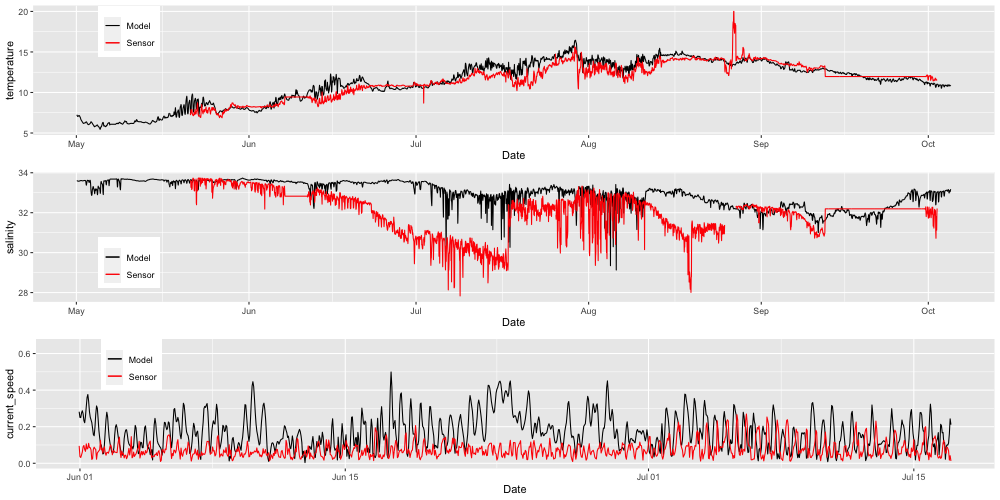

┌ Warning: RCall.jl: Warning: Removed 2663 row(s) containing missing values (geom_path).
│ Warning: Removed 720 row(s) containing missing values (geom_path).
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160


RObject{VecSxp}
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]


In [12]:
@rput  df_sens speed_sens
R"""
library(ggplot2);library(gridExtra)

p1=ggplot(data=$df,aes(Date, temperature))+geom_line(aes(color = 'black')) + 
geom_line( data = df_sens, aes(Date, temperature_sens, color = 'red')) +  
scale_color_manual(labels = c("Model", "Sensor"), values = c("black", "red")) + # theme_bw() + 
theme(legend.title = element_blank(),  legend.position = c(0.1, 0.8)) 

p2=ggplot(data=$df,aes(Date, salinity))+geom_line(aes( color = 'black')) + 
geom_line( data = df_sens, aes(Date, salinity_sens, color = 'red')) +  
scale_color_manual(labels = c("Model", "Sensor"), values = c("black", "red")) + # theme_bw() + 
theme(legend.title = element_blank(),  legend.position = c(0.1, 0.3)) 
lims <- as.POSIXct(strptime(c("2019-06-01 00:00", "2019-07-17 00:00"), 
                   format = "%Y-%m-%d %H:%M"))
p3=ggplot(data=$df,aes(Date, current_speed))+geom_line(aes( color = 'black')) + 
geom_line( data = speed_sens, aes(Date, current_speed_sens/100., color = 'red')) +  
scale_color_manual(labels = c("Model", "Sensor"), values = c("black", "red")) + #theme_bw() + 
theme(legend.title = element_blank(),  legend.position = c(0.1, 0.8)) +
scale_x_datetime(limits = lims) 
g = grid.arrange(p1,p2,p3, nrow=3)
"""

### Extract features for ML
Data are curated and blended from environmental sensor, ocean model, and weather product data. <br>
Final step of feature engineering is to extract time features

In [13]:
dfs = df[:,1:2]
rename!(dfs,Dict(:Height => :Value))
cargs = Dict(:ahead=>1,:size=>3,:stride=>1)
dateifier=Dateifier(cargs)
matrifier=Matrifier(cargs)
datemx=fit_transform!(dateifier,dfs) .|> identity
valmx=fit_transform!(matrifier,dfs) .|> identity
datemx.Date = [DateTime(x.year,x.month,x.day,x.hour) for x in eachrow(datemx)]
datevalmx = hcat(datemx,valmx)
fdf=innerjoin(datevalmx,df,on=:Date);

### Filter: data > June 15 to avoid noise/missing/interpolated data based on plot

In [14]:
rfdf = fdf[fdf[!, :Date] .> DateTime(2019,06,15,00,00), :]
tail(rfdf)

5×30 DataFrame
 Row │ year   month  day    hour   week   dow    doq    qoy    Date                 x1       x2       x3       output   Height   temperature  salinity  surface_temperature  downward_solar_radiation  diffuseHorizontalRadiationWsqm  wind_speed  wind_direction  cloud_cover  precipitation  wind_sindir  wind_cosdir  current_speed  current_direction  sindir     cosdir     SSH     
     │ Int64  Int64  Int64  Int64  Int64  Int64  Int64  Int64  DateTime             Float64  Float64  Float64  Float64  Float64  Float64      Float64   Float64              Float64                   Float64                         Float64     Int64           Int64        Float64        Float64      Float64      Float64        Float64            Float64    Float64    Float64 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  2019      6     15      5     24      6     76      2  2019-06-15T05:00:00  2.92466  3.45067  4.45116  4.77212  4.45116        10.61    33.225                 10.8                     113.0                            43.0         5.3              21           27            0.0     0.358368     0.93358       0.0250799          156.501     0.398726  -0.91707    -0.886
   2 │  2019      6     15      4     24      6     76      2  2019-06-15T04:00:00  2.95298  2.92466  3.45067  4.45116  3.45067        10.78    33.159                 10.5                      57.0                            30.0         5.3              25           21            0.0     0.422618     0.906308      0.0620081          142.206     0.612824  -0.79022    -0.394
   3 │  2019      6     15      3     24      6     76      2  2019-06-15T03:00:00  3.97919  2.95298  2.92466  3.45067  2.92466        10.87    33.141                 10.4                      20.0                            19.0         5.6              31           28            0.0     0.515038     0.857167      0.0744648          157.913     0.376017  -0.926613   -0.124
   4 │  2019      6     15      2     24      6     76      2  2019-06-15T02:00:00  4.49388  3.97919  2.95298  2.92466  2.95298        11.26    32.945                 10.6                       5.0                             5.0         5.8              16           28            0.0     0.275637     0.961262      0.0382884          -49.2364   -0.75741    0.65294     0.027
   5 │  2019      6     15      1     24      6     76      2  2019-06-15T01:00:00  4.45283  4.49388  3.97919  2.95298  3.97919        10.46    33.405                 10.8                       2.0                             2.0         8.0              17           29            0.0     0.292372     0.956305      0.156016            -9.22082  -0.16024    0.987078    0.274

### Convert to factors nominal/ordinal features

In [15]:
@rput rfdf
R"colnames=c('year','month','hour','week','dow','day','qoy','doq')";
R"rfdf[colnames] <- lapply(rfdf[colnames] , factor)";

### Statistical characterisation of fish cage data

Understanding farm dynamics requires a greater characterisation of fish variations within a cage. Fundamentally these consider: <br>
1. Temporal variations 
2. Fish behaviour in response to external environmental conditions
3. Fish behaviour in response to extreme conditions (e.g. storm, predation, disease)

Many different biological, environmental and social parameters influence the behaviour of salmon when farmed in sea cages. Parasites, such as sea lice, are a biological example that can cause behavioural changes to farmed salmon in order to combat infestation. Sea lice are concentrated near the surface, and fish have been observed to prefer deeper depths once highly infested to avoid further infestation (Bui et. al., 2016). Temperature and dissolved oxygen (DO) are an example of environmental parameters that effect behaviour of Atlantic salmon. For example, Atlantic salmon will distribute themselves according to preferred temperature range, 8--18$^{\circ}$C, with changes in behaviour occurring above and below the threshold (Johansson et. al., 2009). Similarly, DO is an important parameter affecting fish behaviour as concentrations below the optimal range cause physiological stress and related behavioural changes such as a reduction in feeding (Dempster et. al., 2016). Light intensity is another major contributor to fish behaviour by changing vertical distribution. During daylight hours, when light intensity is at its greatest, fish tend to swim deeper in net pens to avoid surface predators (Oppedal et. al. 2001). It has been hypothesized ascent towards the surface during nighttime is a photo-regulatory behaviour to maintain schooling as light fades. Furthermore, seasonal variation in light availability changes vertical distribution with winter swimming depths generally shallower than summer swimming depths.

#### References
Bui, S., Oppedal, F., Stien, L., and Dempster, T. (2016). Sea lice infestation level alters salmon swimming depth in sea-cages. Aquaculture Environment Interactions 8, 429–435 <br>
Johansson, D., Ruohonen, K., Juell, J.-E., and Oppedal, F. (2009). Swimming depth and thermal history of individual atlantic salmon (Salmo salar L.) in production cages under different ambient temperature conditions. Aquaculture 290, 296–303<br>
Dempster, T., Wright, D., and Oppedal, F. (2016). Identifying the nature, extent and duration of critical producation periods for Atlantic salmon in Macquarie Harbour, Tasmania, during summer. Fisheries Research and Development Corporation report , 1–16<br>
Oppedal, F., Juell, J.-E., Tarranger, G., and Hansen, T. (2001). Artificial light and season affects vertical distribution and swimming behaviour of post-smolt Atlantic salmon in sea cages. Journal of Fish Biology 58, 1570–1584

### 1) We want to understand how cage dynamics vary hourly

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ tibble  3.1.0     ✔ dplyr   1.0.5
│ ✔ tidyr   1.1.3     ✔ stringr 1.4.0
│ ✔ readr   1.4.0     ✔ forcats 0.5.1
│ ✔ purrr   0.3.4     
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::combine() masks gridExtra::combine()
│ ✖ dplyr::filter()  masks stats::filter()
│ ✖ dplyr::lag()     masks stats::lag()
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: 
│ Attaching package: ‘rstatix’
│ 
│ The following object is masked from ‘package:stats’:
│ 
│     filter
│ 
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160


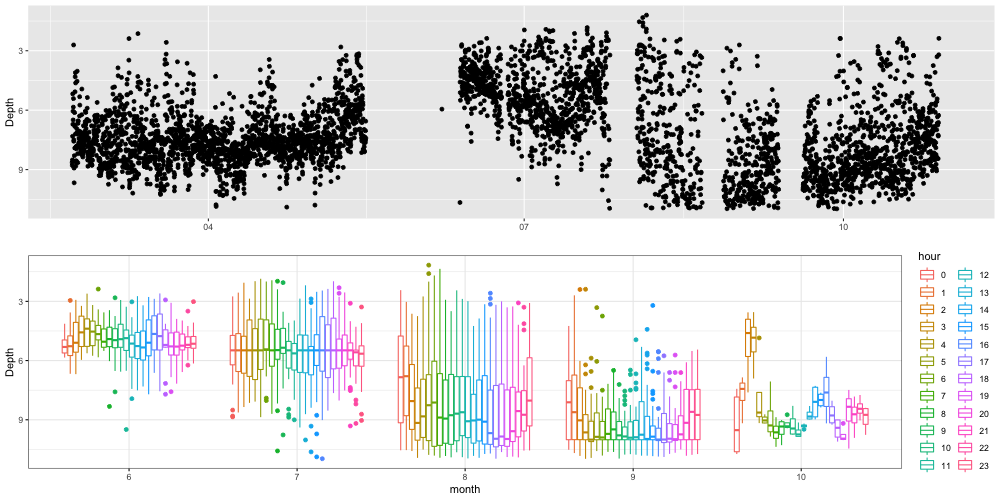

┌ Warning: RCall.jl: Warning: Removed 1375 rows containing missing values (geom_point).
└ @ RCall /Users/fearghalodonncha/.julia/packages/RCall/iMDW2/src/io.jl:160


RObject{VecSxp}
TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange  gtable[layout]
2 2 (2-2,1-1) arrange gtable[arrange]


In [16]:
R"""
library(tidyverse)
library(rstatix)
library(ggpubr)
gg = ggsummarystats(
  rfdf, x = "month", y = "output", ylab="Depth",
  ggfunc = ggboxplot, color="hour",orientation = c("reverse"), #add = 'jitter', -- if we add jitter it adds points over each boxplot which makes difficult to read: remove
  ggtheme = theme_bw() 
  );
p1=ggplot(data=mdata)+geom_point(aes(Timestamp,AverageDepth)) + ylab('Depth')  +
  scale_y_continuous(trans = 'reverse') + scale_x_datetime(date_labels = "%m") + xlab('');
grid.arrange(p1,arrangeGrob(grobs = gg[1]))
"""


### 1) We want to understand how cage dynamics vary daily

In [17]:
rfdf2 = rfdf[rfdf[!, :Date] .> DateTime(2019,9,1,0,0), :]
day = rfdf2[(rfdf2[!, :hour] .> 6) .& (rfdf2[!, :hour] .< 19), :]
night = rfdf2[rfdf2[!, :hour] .> 18, :]
night2 = rfdf2[rfdf2[!, :hour] .< 7, :]
day[!, :DayNight] .= "D"
night[!, :DayNight] .= "N"
night2[!, :DayNight] .= "N"  # little awkward way of doing it
dfnd =  [day;night;night2];

### Let's create a density plot of day/night variations 

In [18]:
@rput dfnd
R"""
#library('plyr')

mu <- ddply(dfnd, "DayNight", summarise, grp.mean=mean(output))
ggplot(dfnd, aes(x=output, fill=DayNight)) +
  geom_density()
# Use semi-transparent fill
p<-ggplot(dfnd, aes(x=output, fill=DayNight)) +
  geom_density(alpha=0.4)
p
# Add mean lines

p+geom_vline(data=mu, aes(xintercept=grp.mean, color=DayNight),
             linetype="dashed")
"""

LoadError: REvalError: Error in ddply(dfnd, "DayNight", summarise, grp.mean = mean(output)) : 
  could not find function "ddply"

### Model 1: let's explore all variables and their importance
Features to the model can be categorised as temporal, ocean, and weather variables. We interrogate these to understand how fish dynamics in a cage vary in response to external variations. <br>
<br> 
It's necessary to understand how effectively the model captures dynamics and secondly what the drivers of those dynamics are.
#### Explained variance

In [ ]:
## Let's explore time features  month+hour+week+dow+qoy+
R"""
library(randomForest);
fm1 = as.formula('output ~  hour+day+dow+week+month+ x3+x2+x1+ temperature+salinity+current_speed+sindir+ cosdir+wind_speed + wind_sindir + wind_cosdir+SSH');
rfmodel1=randomForest(fm1,data = rfdf);
rfmodel1
"""

#### Feature Importance
Interrogate all features: this helps the data scientist to craft feature selection but it can be a valuable tool to help the domain expert understand the sensitivity of the system. <br>

In simple terms, effective model development is a combination of data-driven interrogation of variance and domain knowledge on primary variables that influence fish behaviour.

Kuhn and Johnson (2013) summarised how selecting the most appropriate set of features is critical to maximising model performance, while from a practical point of view a model with less predictors may be more interpretable

__References__
Kuhn, M., Johnson, K., et al. (2013). Applied predictive modeling, vol. 26 (Springer)

In [ ]:
R"varImpPlot(rfmodel1)";

### Model 2: Let's select variables based on domain knowledge
Our second experimental setup involved a reduced set of features, namely: temperature, DO, current speed, wind speed, and salinity, together with hour-of-day. Choice of features were based on both feature importance computed above, and those suggested by literature.
Naturally, the variance explained (or predictive skill) of the model dropped with the reduced feature set, but the analysis of feature importance or contributions can be more meaningful. The resultant model explained 59% of data, (a drop of 17% compared to the model with all features provided). This drop in predictive skill was balanced by an improvement in model __interpretability__ and increased focus on pertinent environmental drivers.

In [ ]:
R"""
library('iml')
fm3 = as.formula('output ~  temperature+salinity+current_speed+current_direction + wind_direction+SSH')
rfmodel2=randomForest(fm3,data = rfdf)
X = rfdf[,c("temperature","salinity","current_speed","current_direction", "wind_direction", "SSH")]
y = rfdf$output
model = Predictor$new(rfmodel2, data = X, y = y );
rfmodel2
"""

### Now plot the feature importance
From a feature analysis perspective, this allows us to confidently interrogate results since we are primarily interested in variations in output rather than magnitude (i.e. changes of fish position in response to changes in environmental conditions rather than the magnitude of those changes)
We used the model to understand variance explained by these drivers together with the feature importance of each.

In [ ]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 500));
R"""
imp <- FeatureImp$new(model, loss = "mae")
plot(imp) + theme_bw() +xlab("Feature Importance") + 
theme(axis.text=element_text(size=12),
        axis.title=element_text(size=14,face="bold"))
"""

### Local effects
While above analysis provide insight into which features were important, we were interested in how the features influence the predicted outcome.
A powerful approach to interrogate the variations of predictand in response to predictors are _accumulated local effects_ (ALE) (Apley and Zhu, 2020).
ALE quantifies the contributions of different predictors by considering the conditional probability or likelihood of changes to prediction. It has noted advantages in cases where multiple predictors are correlated and the effects are difficult to separate. This is hugely appealing in natural systems such as marine aquaculture.

#### ALE Interpretation
ALE provides a quantitative way to show how the prediction (fish position) changes locally, when the feature (environmental variable) is varied.
The marks on the x-axis indicates the distribution of the particular feature, showing how relevant a region is for interpretation (little or no points mean that we should not over-interpret this region).


__REFERENCES__
Apley, D. W. and Zhu, J. (2020). Visualizing the effects of predictor variables in black box supervised learning models. Journal of the Royal Statistical Society: Series B (Statistical Methodology) 82, 1059–1086


In [ ]:
R"""
effect = FeatureEffects$new(model,method = "ale")
effect$plot(features = c("salinity", "SSH", "current_direction", "current_speed"))
"""

### ALE Analysis
Analysis indicates that fish tend deeper in the water column during higher salinity levels. Literature indicates that Atlantic salmon are influenced by salinity variations when younger than three months and during spawning periods, while indifferent to salinity at other times (Oppedal et. al. 2011). The behavioural influence detected in this study may be a result of salmon expressing preference for lower salinity waters in spring, during the return migration period of salmon towards freshwater. However, it is critical to combine data driven analysis such as this with detailed investigation of sensitivities and robustness.

Similarly there is a clear relationship between SSSH and fish depth. Fish tends to move higher in the water column at lower water levels. This is possibly a response to complex bay-scale dynamics that develop on flood and ebb tide (i.e. when water is flowing into the bay during flood tide or exiting the bay during ebb tide)

__REFERENCES:__
Oppedal, F., Dempster, T., and Stien, L. H. (2011). Environmental drivers of Atlantic salmon behaviour in sea-cages: A review. Aquaculture 311, 1–18

# Further Reading
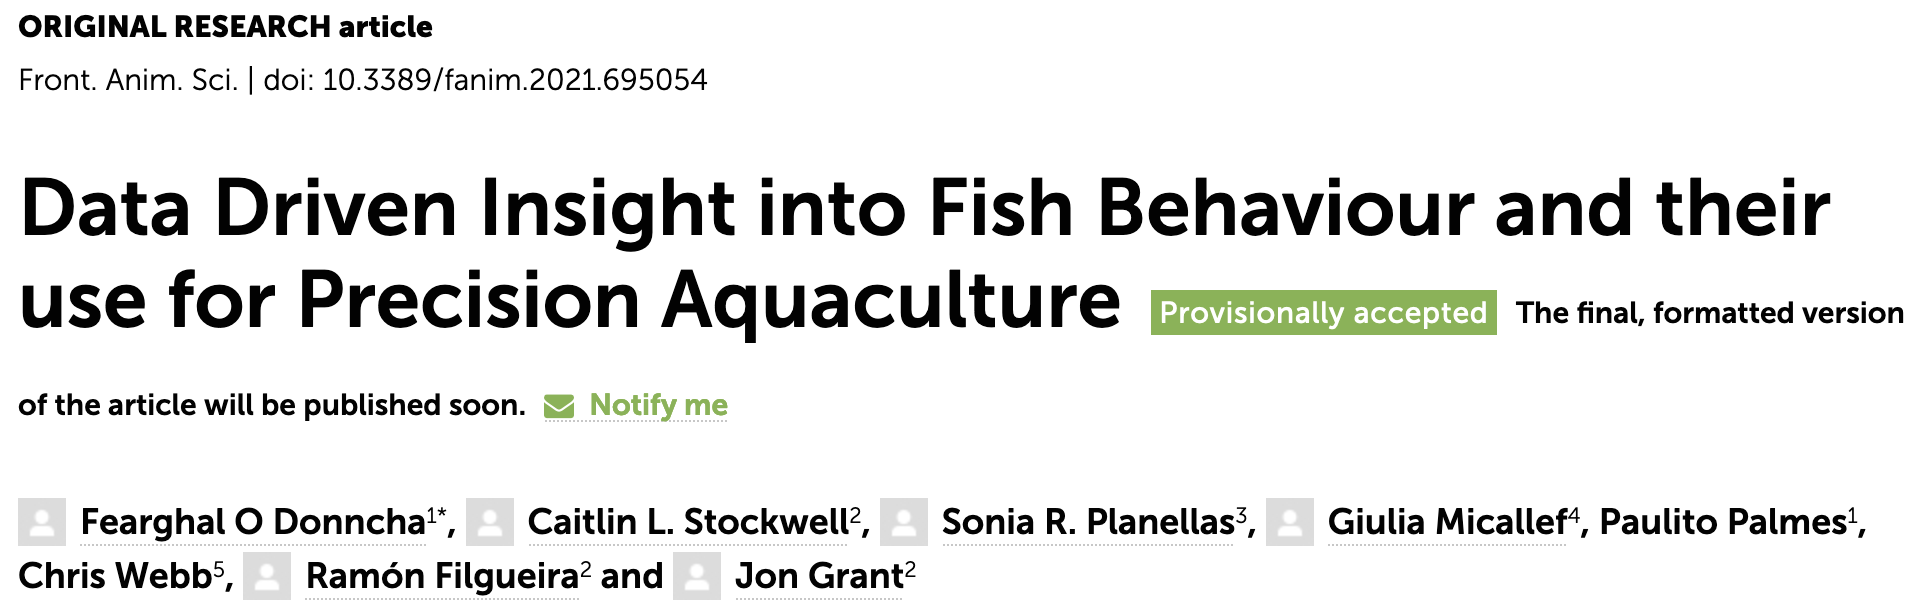